### 3 Visualization - Prediction Confidence Heatmaps

A sliding window approach was applied on the whole slide images (WSIs) with the trained CNN model to generate confidence heatmaps. 

The WSIs were tiled into 1536 x 1536 images patches in the prepocessing steps. A sliding window approached was applied on evey image patch of a WSI. At each time, the CNN model took a 256x256 pixels region as input, forward propagated and generated a prediction score for cored plaque, diffuse plaque and CAA respectively. By systematically sliding the input region across the entire 1536 x 1536 image patch, the prediction scores were saved and ploted as prediction confidence heatmap for this patch. The heatmap for the WSI was obtained by doing this on all image patches of it.

In [1]:
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pyvips as Vips
from tqdm import tqdm

from utils import vips_utils, normalize

In [2]:
# Directories
WSI_DIR = 'data/box/'
SAVE_DIR = 'data/tester/'

In [ ]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [3]:
ref_imagename = 'NA3777-02_AB.svs'

In [4]:
wsi_slides = os.listdir(WSI_DIR)
imagenames = sorted(wsi_slides)
print(imagenames)

['NA3777-02_AB.svs']


In [ ]:
%%time
# Load reference image, fit Reinhard normalizer
ref_image = Vips.Image.new_from_file(WSI_DIR + ref_imagename, level=0)

normalizer = normalize.Reinhard()
normalizer.fit(ref_image)

In [ ]:
# Perform Preprocessing: Reinhard Normalization
stats_dict = {}
for imagename in tqdm(imagenames[:]):
    
    vips_img = Vips.Image.new_from_file(WSI_DIR + imagename, level=0)
    print("Loaded Image: " + WSI_DIR + imagename)
    
    out = normalizer.transform(vips_img)
#     out.filename = vips_img.filename
    vips_utils.save_and_tile(out, imagename, SAVE_DIR)
    stats_dict[imagename] = normalizer.image_stats

In [ ]:
# Some Statistics about WSI Slide
import pandas as pd
stats = pd.DataFrame(stats_dict)
stats = stats.transpose()
stats.columns = 'means', 'stds'
print(stats)

### 2) Main Pipeline for Inference

Estimation time per WSI slide: 4.5 hrs on Titan XP

In [2]:
import time, os, glob

import torch
torch.manual_seed(123456789)
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm import tqdm
import copy

print(torch.__version__, torchvision.__version__)

1.4.0 0.5.0


In [3]:
IMG_DIR  = 'data/norm_tiles/'

# Plaque Detection
MODEL_PLAQ_DIR = 'models/CNN_model_parameters.pkl'
SAVE_PLAQ_DIR = 'data/outputs/heatmaps/'

# Brainseg
MODEL_SEG_DIR = 'models/ResNet18_19.pkl'
SAVE_IMG_DIR = 'data/brainseg/images/'
SAVE_NP_DIR = 'data/brainseg/numpy/'

# Plaque Detection
MODEL_PLAQ_DIR = 'models/CNN_model_parameters.pkl'
SAVE_PLAQ_DIR = 'data/tester/heatmaps/'

# Brainseg
MODEL_SEG_DIR = 'models/ResNet18_19.pkl'
SAVE_IMG_DIR = 'data/tester/images/'
SAVE_NP_DIR = 'data/tester/numpy/'

In [4]:
if not os.path.exists(SAVE_PLAQ_DIR):
        os.makedirs(SAVE_PLAQ_DIR)
        
if not os.path.exists(SAVE_IMG_DIR):
        os.makedirs(SAVE_IMG_DIR)
        
if not os.path.exists(SAVE_NP_DIR):
        os.makedirs(SAVE_NP_DIR)

In [5]:
img_size = 1536
stride = 16
batch_size = 32 
num_workers = 16
# Note: BrainSeg can only work in 
# batch_size of 1, 8, 16, 32, 96
# in the way it is coded (not 64)
# To check: (96/batch_size) == int

# The values between Plaquebox & Brainseg are about the same
# norm = np.load('utils/normalization.npy', allow_pickle=True).item() # plaquebox
# normalize = transforms.Normalize(norm['mean'], norm['std'])
# print(normalize)
norm = np.load('norm_brainseg/normalization.npy', allow_pickle=True).item() # brainseg
normalize = transforms.Normalize(norm['mean'], norm['std'])
# print(normalize)

to_tensor = transforms.ToTensor()

# Retrieve Files
filenames = glob.glob(IMG_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
filenames = sorted(filenames)
# print(filenames)

In [6]:
from torch.utils.data import Dataset

class HeatmapDataset(Dataset):
    def __init__(self, tile_dir, row, col, stride=1):
        """
        Args:
            tile_dir (string): path to the folder where tiles are
            row (int): row index of the tile being operated
            col (int): column index of the tile being operated
            stride: stride of sliding 
        """
        self.tile_size = 256
        self.img_size = 1536
        self.stride = stride
        padding = 128
        large_img = torch.ones(3, 3*self.img_size, 3*self.img_size)
        
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                img_path = tile_dir+'/'+str(row+i)+'/'+str(col+j)+'.jpg'
                try:
                    img = Image.open(img_path)
                    img = transforms.ToTensor()(img) 
                except:
                    img = torch.ones(3,self.img_size, self.img_size)
                
                large_img[:, (i+1)*self.img_size:(i+2)*self.img_size,(j+1)*self.img_size:(j+2)*self.img_size] = img
        
        large_img = normalize(large_img)
        
        self.padding_img = large_img[:,self.img_size-padding:2*self.img_size+padding, self.img_size-padding:2*self.img_size+padding]
        self.len = (self.img_size//self.stride)**2
        
    def __getitem__(self, index):

        row = (index*self.stride // self.img_size)*self.stride
        col = (index*self.stride % self.img_size)

        img = self.padding_img[:, row:row+self.tile_size, col:col+self.tile_size]        
    
        return img

    def __len__(self):
        return self.len

In [7]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [9]:
# Check GPU:
use_gpu = torch.cuda.is_available()

# instatiate the model
plaq_model = torch.load(MODEL_PLAQ_DIR, map_location=lambda storage, loc: storage)
seg_model = torch.load(MODEL_SEG_DIR, map_location=lambda storage, loc: storage)

if use_gpu:
    seg_model = seg_model.cuda() # Segmentation
    plaq_model = plaq_model.module.cuda() # Plaquebox-paper
else:
    seg_model = seg_model
    plaq_model = plaq_model.module

In [10]:
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)
    

In [ ]:
import time
# Inference Loop:

for filename in filenames[:] :
    print("Now processing: ", filename)
    
    # Retrieve Files
    TILE_DIR = IMG_DIR+'{}/0/'.format(filename)

    imgs = []
    for target in sorted(os.listdir(TILE_DIR)):
        d = os.path.join(TILE_DIR, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if fname.endswith('.jpg'):
                    path = os.path.join(root, fname)
                    imgs.append(path)

    rows = [int(image.split('/')[-2]) for image in imgs]
    row_nums = max(rows) + 1
    cols = [int(image.split('/')[-1].split('.')[0]) for image in imgs]
    col_nums = max(cols) +1    
    
    # Initialize outputs accordingly:
    heatmap_res = img_size // stride
    plaque_output = np.zeros((3, heatmap_res*row_nums, heatmap_res*col_nums))
    seg_output = np.zeros((heatmap_res*row_nums, heatmap_res*col_nums), dtype=np.uint8)

    seg_model.train(False)  # Set model to evaluate mode
    plaq_model.train(False)
    
    start_time = time.perf_counter() # To evaluate Time taken per inference

    for row in tqdm(range(row_nums)):
        for col in range(col_nums):

            image_datasets = HeatmapDataset(TILE_DIR, row, col, stride=stride)
            dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                                 shuffle=False, num_workers=num_workers)
            
            # From Plaque-Detection:
            running_plaques = torch.Tensor(0)
            # For Stride 32 (BrainSeg):
            running_seg = torch.zeros((32), dtype=torch.uint8)
            output_class = np.zeros((heatmap_res, heatmap_res), dtype=np.uint8)
            
            for idx, data in enumerate(dataloader):
                # get the inputs
                inputs = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(), volatile=True)
                    
                    # forward (Plaque Detection) :
                    outputs = plaq_model(inputs)
                    preds = F.sigmoid(outputs) # Posibility for each class = [0,1]
                    preds = preds.data.cpu()
                    running_plaques = torch.cat([running_plaques, preds])
                    
                    # forward (BrainSeg) :
                    predict = seg_model(inputs)
                    _, indices = torch.max(predict.data, 1) # indices = 0:Background, 1:WM, 2:GM
                    indices = indices.type(torch.uint8)
                    running_seg =  indices.data.cpu()

                    # For Stride 32 (BrainSeg) :
                    i = (idx // (heatmap_res//batch_size))
                    j = (idx % (heatmap_res//batch_size))
                    output_class[i,j*batch_size:(j+1)*batch_size] = running_seg
            
            # Final Outputs of Brain Segmentation
            seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class
            
            # Final Outputs of Plaque Detection:
            cored = np.asarray(running_plaques[:,0]).reshape(img_size//stride,img_size//stride)
            diffuse = np.asarray(running_plaques[:,1]).reshape(img_size//stride,img_size//stride)
            caa = np.asarray(running_plaques[:,2]).reshape(img_size//stride,img_size//stride)
            
            plaque_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
            plaque_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
            plaque_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

            seg_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class

    # Saving Confidence=[0,1] for Plaque Detection
    np.save(SAVE_PLAQ_DIR+filename, plaque_output)
    
    # Saving BrainSeg Classification={0,1,2}
    np.save(SAVE_NP_DIR+filename, seg_output)
    saveBrainSegImage(seg_output, \
                      SAVE_IMG_DIR + filename + '.png')
    
    # Time Statistics for Inference
    end_time = time.perf_counter()
    print("Time to process " \
          + filename \
          + ": ", end_time-start_time, "sec")

  0%|          | 0/31 [00:00<?, ?it/s]

Now processing:  NA3777-02_AB


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  0%|          | 0/31 [00:00<?, ?it/s]

Saved at: data/tester/images/NA3777-02_AB.png
Time to process NA3777-02_AB:  16175.736632479355 sec
Now processing:  NA4077-02_AB


  3%|▎         | 1/31 [12:46<6:23:19, 766.66s/it]

NameError: name 'final_output' is not defined

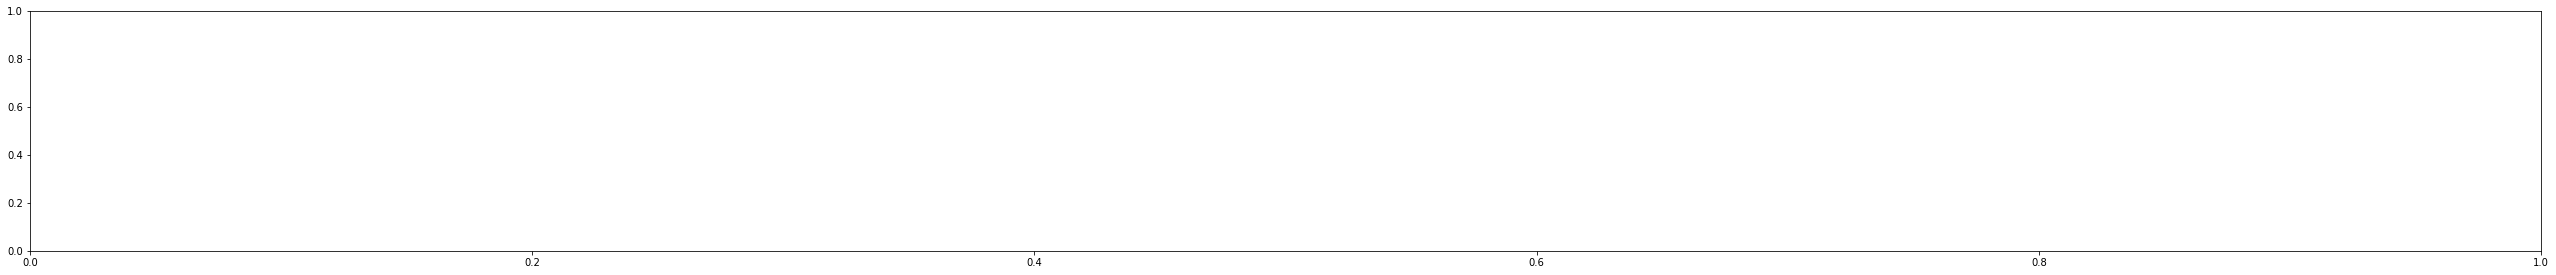

In [24]:
def plot_heatmap(final_output) :
    """
    Plots Confidence Heatmap of Plaques = [0,1]
    
    Inputs:
        final_output (NumPy array of 
        3*img_height*height_width) :
            Contains Plaque Confidence with each axis
            representing different types of plaque
            
    Outputs:
        Subplots containing Plaque Confidences
    """
    fig = plt.figure(figsize=(45,15))

    ax = fig.add_subplot(311)

    im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(312)

    im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

    ax = fig.add_subplot(313)

    im = ax.imshow(final_output[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

### 3) Post-processing and Counting Plaques at each Segmentation Area

In [3]:
import csv
import glob, os

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import measure
from scipy import stats

from tqdm import tqdm

In [4]:
from PIL import Image
def saveBrainSegImage(nums, save_dir) :
    """
    Converts 2D array with {0,1,2} into RGB
     to determine different segmentation areas
     and saves image at given directory
    
    Input:
       nums: 2D-NumPy Array containing classification
       save_dir: string indicating save location
    """ 
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 1)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 2)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to yellow color: R255G255B0 (WM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 0
    # For label 2, set to cyan color: R0G255B255 (GM)
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 255

    nums = nums.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [5]:
from PIL import Image
import numpy as np
from scipy import ndimage
from skimage import morphology, measure
# import lxml.etree as ET
from tqdm import tqdm

# Post-Processing BrainSeg - Jeff, Kolin, Wenda
def method_6(mask_img: "Image", down_factor=4) -> "NDArray[np.uint8]":
    """Downsample => Area_opening (Remove local maxima) =>
    Swap index of GM and WM => Area_opening => Swap index back =>
    Area_closing => Morphological opening => Upsample"""
    # pylint: disable=invalid-name
    def swap_GM_WM(arr):
        """Swap GM and WM in arr (swaps index 1 and index 2)"""
        arr_1 = (arr == 1)
        arr[arr == 2] = 1
        arr[arr_1] = 2
        del arr_1
        return arr
    # pylint: enable=invalid-name

    mask_img = Image.fromarray(mask_img)
    width, height = mask_img.width, mask_img.height
    area_threshold_prop = 0.05
    area_threshold = int(area_threshold_prop * width * height // down_factor**2)

    # Downsample the image
    mask_arr = np.array(
        mask_img.resize((width // down_factor, height // down_factor), Image.NEAREST))
    del mask_img
    print('Finish downsampling')

    # Apply area_opening to remove local maxima with area < 20000 px
    mask_arr = morphology.area_opening(mask_arr, area_threshold=320000 // down_factor**2)
    print('Finish area_opening #1')

    # Swap index of GM and WM
    mask_arr = swap_GM_WM(mask_arr)
    print('Finish swapping index')

    # Apply area_opening to remove local maxima with area < 20000 px
    mask_arr = morphology.area_opening(mask_arr, area_threshold=320000 // down_factor**2)
    print('Finish area_opening #2')

    # Swap index back
    mask_arr = swap_GM_WM(mask_arr)
    print('Finish swapping index back')

    # Apply area_closing to remove local minima with area < 12500 px
    mask_arr = morphology.area_closing(mask_arr, area_threshold=200000 // down_factor**2)
    print('Finish area_closing')

    # Apply remove_small_objects to remove tissue residue with area < 0.05 * width * height
    tissue_arr = morphology.remove_small_objects(mask_arr > 0, min_size=area_threshold,
                                                 connectivity=2)
    mask_arr[np.invert(tissue_arr)] = 0
    del tissue_arr
    print('Finish remove_small_objects')

    # Apply opening with disk-shaped kernel (r=8) to smooth boundary
    mask_arr = morphology.opening(mask_arr, selem=morphology.disk(radius=32 // down_factor))
    print('Finish morphological opening')

    # Upsample the output
    mask_arr = np.array(Image.fromarray(mask_arr).resize((width, height), Image.NEAREST))
    print('Finish upsampling')

    return mask_arr

In [6]:
# Plaque-counting Directories
CSV_DIR = 'data/outputs/CNNscore/WSI_CERAD_AREA.csv'
HEATMAP_DIR = 'data/outputs/heatmaps/'
SAVE_DIR = 'data/outputs/CNNscore/'

# BrainSeg Post-processing Directories
BRAINSEG_NP_PRE_DIR = 'data/brainseg/numpy/'
POST_IMG_DIR = 'data/postprocess/images/'
POST_NP_DIR = 'data/postprocess/numpy/'

# Counted Plaques Save Directories
SAVE_IMG_DIR = 'data/outputs/masked_plaque/images/'
SAVE_NP_DIR = 'data/outputs/masked_plaque/numpy/'
# print(os.listdir(BRAINSEG_NP_PRE_DIR))

In [7]:
filenames = sorted(os.listdir(BRAINSEG_NP_PRE_DIR))
filenames = [os.path.splitext(file)[0] for file in filenames]
print(filenames)

['NA3777-02_AB', 'NA4077-02_AB', 'NA4092-02_AB', 'NA4107-02_AB', 'NA4160-02_AB', 'NA4195-02_AB', 'NA4256-02_AB', 'NA4299-02_AB', 'NA4391-02_AB', 'NA4450-02_AB', 'NA4463-02_AB', 'NA4471-02_AB', 'NA4553-02_AB', 'NA4626-02_AB', 'NA4672-02_AB', 'NA4675-02_AB', 'NA4691-02_AB', 'NA4695-02_AB']


In [21]:
# Post-process BrainSeg
for filename in tqdm(filenames) :
    fileLoc = BRAINSEG_NP_DIR + filename + ".npy"
    print("Loading: " + fileLoc)
    seg_pic = np.load(fileLoc)
    processed = method_6(seg_pic)
    np.save(POST_NP_DIR+filename, processed)
    saveBrainSegImage(processed, \
                      POST_IMG_DIR + filename + '.png')

  0%|          | 0/18 [00:00<?, ?it/s]

Loading: data/brainseg/numpy/NA3777-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


  6%|▌         | 1/18 [00:04<01:20,  4.74s/it]

Saved at: data/postprocess/images/NA3777-02_AB.png
Loading: data/brainseg/numpy/NA4077-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 11%|█         | 2/18 [00:10<01:22,  5.18s/it]

Saved at: data/postprocess/images/NA4077-02_AB.png
Loading: data/brainseg/numpy/NA4092-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 17%|█▋        | 3/18 [00:16<01:20,  5.34s/it]

Saved at: data/postprocess/images/NA4092-02_AB.png
Loading: data/brainseg/numpy/NA4107-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 22%|██▏       | 4/18 [00:21<01:11,  5.12s/it]

Saved at: data/postprocess/images/NA4107-02_AB.png
Loading: data/brainseg/numpy/NA4160-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 28%|██▊       | 5/18 [00:25<01:04,  4.97s/it]

Saved at: data/postprocess/images/NA4160-02_AB.png
Loading: data/brainseg/numpy/NA4195-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 33%|███▎      | 6/18 [00:30<00:56,  4.73s/it]

Saved at: data/postprocess/images/NA4195-02_AB.png
Loading: data/brainseg/numpy/NA4256-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 39%|███▉      | 7/18 [00:35<00:55,  5.02s/it]

Saved at: data/postprocess/images/NA4256-02_AB.png
Loading: data/brainseg/numpy/NA4299-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 44%|████▍     | 8/18 [00:40<00:49,  4.96s/it]

Saved at: data/postprocess/images/NA4299-02_AB.png
Loading: data/brainseg/numpy/NA4391-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 50%|█████     | 9/18 [00:45<00:43,  4.80s/it]

Saved at: data/postprocess/images/NA4391-02_AB.png
Loading: data/brainseg/numpy/NA4450-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 56%|█████▌    | 10/18 [00:50<00:39,  4.89s/it]

Saved at: data/postprocess/images/NA4450-02_AB.png
Loading: data/brainseg/numpy/NA4463-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 61%|██████    | 11/18 [00:55<00:34,  4.90s/it]

Saved at: data/postprocess/images/NA4463-02_AB.png
Loading: data/brainseg/numpy/NA4471-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 67%|██████▋   | 12/18 [01:00<00:31,  5.20s/it]

Saved at: data/postprocess/images/NA4471-02_AB.png
Loading: data/brainseg/numpy/NA4553-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 72%|███████▏  | 13/18 [01:06<00:26,  5.35s/it]

Saved at: data/postprocess/images/NA4553-02_AB.png
Loading: data/brainseg/numpy/NA4626-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 78%|███████▊  | 14/18 [01:10<00:19,  4.93s/it]

Saved at: data/postprocess/images/NA4626-02_AB.png
Loading: data/brainseg/numpy/NA4672-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 83%|████████▎ | 15/18 [01:13<00:13,  4.47s/it]

Saved at: data/postprocess/images/NA4672-02_AB.png
Loading: data/brainseg/numpy/NA4675-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 89%|████████▉ | 16/18 [01:18<00:09,  4.53s/it]

Saved at: data/postprocess/images/NA4675-02_AB.png
Loading: data/brainseg/numpy/NA4691-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


 94%|█████████▍| 17/18 [01:22<00:04,  4.44s/it]

Saved at: data/postprocess/images/NA4691-02_AB.png
Loading: data/brainseg/numpy/NA4695-02_AB.npy
Finish downsampling
Finish area_opening #1
Finish swapping index
Finish area_opening #2
Finish swapping index back
Finish area_closing
Finish remove_small_objects
Finish morphological opening
Finish upsampling


100%|██████████| 18/18 [01:27<00:00,  4.85s/it]

Saved at: data/postprocess/images/NA4695-02_AB.png


In [8]:
# UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18,
# use 'connectivity' instead. For neighbors=8, use connectivity=2
#   This is separate from the ipykernel package so we can avoid doing imports until

# Post-Processing to count Plaques
def count_blobs(mask,
               threshold=1500):
#     labels = measure.label(mask, neighbors=8, background=0)
    labels = measure.label(mask, connectivity=2, background=0)
    img_mask = np.zeros(mask.shape, dtype='uint8')
    labeled_mask = np.zeros(mask.shape, dtype='uint16')
    sizes = []
    locations = []
    
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
        # otherwise, construct the label mask and count the
        # number of pixels 
        labelMask = np.zeros(mask.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        # if the number of pixels in the component is sufficiently
        # large, then add it to our mask of "large blobs"
        if numPixels > threshold:
            sizes.append(numPixels)
            img_mask = cv2.add(img_mask, labelMask)
            
            # Save confirmed unique location of plaque
            labeled_mask[labels==label] = label

    return sizes, img_mask, labeled_mask

In [9]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_mask(mask_array) :
    """
    Plots Post-processed detected Plaques
    
    Inputs:
        mask_array = img_mask from count_blobs()'s output
    """
    fig = plt.figure(figsize=(45,15))
    ax = fig.add_subplot(111)

    im = ax.imshow(mask_array, cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])
    
    return plt.show()

In [10]:
# from PIL import Image
def saveMask(mask_array, save_dir) :
    
    mask_array = np.repeat(mask_array[:,:, np.newaxis], 3, axis=2)
    
    # mask_array[:,:,0] = RED, mask_array[:,:,1] = Green, mask_array[:,:,2] = Blue
    idx = np.where(mask_array[:,:,0] == 255)  # Index of label 1 (WM)

    # For label 0, leave as black color
    # For label 1, set to cyan color: R0G255B255
    mask_array[:,:,0].flat[np.ravel_multi_index(idx, mask_array[:,:,0].shape)] = 0
    mask_array[:,:,1].flat[np.ravel_multi_index(idx, mask_array[:,:,1].shape)] = 255
    mask_array[:,:,2].flat[np.ravel_multi_index(idx, mask_array[:,:,2].shape)] = 255

    mask_array = mask_array.astype(np.uint8) # PIL save only accepts uint8 {0,..,255}
    save_img = Image.fromarray(mask_array, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)

In [27]:
def classify_blobs(labeled_mask, seg_area) :
    """
    Classifies each certain plaques according to each
    Segmentation Area and gives each count
    
    Input:
        labeled_mask (NumPy Array): 
            contains plaque information 
            Note: See count_blobs()'s 
            labeled_mask output for more info
        
        seg_area (NumPy Array):
            contains segmentation information
            based on BrainSeg's classification
            
    Output:
        count_dict (Dictionary):
            contains number of plaques at each
            segmentaion area
            
        Other Variables:
            - Background Count
            - WM Count
            - GM Count
            - Unclassified Count
    """
    
    # 0: Background, 1: WM, 2: GM
    count_dict = {0: 0, 1: 0, 2: 0, "uncounted": 0}
    # Loop over unique components
    for label in np.unique(labeled_mask) :
        if label == 0:
            continue
            
        plaque_loc = np.where(labeled_mask == label)
        plaque_area = seg_area[plaque_loc]
        indexes, counts = np.unique(plaque_area, return_counts=True)
        class_idx = indexes[np.where(counts == np.amax(counts))]
        
        try:
            class_idx = class_idx.item()
            count_dict[class_idx] += 1
                
        except:
            count_dict["uncounted"] += 1
            
    return count_dict, count_dict[0], count_dict[1], count_dict[2], count_dict["uncounted"]

In [20]:
file = pd.read_csv(CSV_DIR)
filenames = list(file['WSI_ID'])
img_class = ['cored', 'diffuse', 'caa']

# two hyperparameters (For Plaque-Counting)
confidence_thresholds = [0.1, 0.95, 0.9]
pixel_thresholds = [100, 1, 200]

In [28]:
# Post-process Plaque Confidence
# and Count Plaques at each region

new_file = file
for index in [0,1,2]:
    preds = np.zeros(len(file))
    confidence_threshold = confidence_thresholds[index]
    pixel_threshold = pixel_thresholds[index]
    
    bg = np.zeros(len(file))
    wm = np.zeros(len(file))
    gm = np.zeros(len(file))
    unknowns = np.zeros(len(file))

    for i, WSIname in enumerate(tqdm(filenames)):
        try:
            heatmap_path = HEATMAP_DIR+'new_WSI_heatmap_{}.npy'.format(WSIname)
            h = np.load(heatmap_path)

        except:
            heatmap_path = HEATMAP_DIR+'{}.npy'.format(WSIname)
            h = np.load(heatmap_path)
            seg_path = POST_NP_DIR+'{}.npy'.format(WSIname)
            seg = np.load(seg_path)

        mask = h[index] > confidence_threshold
        mask = mask.astype(np.float32)

        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(5,5))

        # Apply morphological closing, then opening operations 
        opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

        labels, img_mask, labeled_mask = count_blobs(closing, threshold=pixel_threshold)
        counts, bg[i], wm[i], gm[i], unknowns[i] = classify_blobs(labeled_mask, seg)
    
        save_img = SAVE_IMG_DIR + WSIname \
                    + "_" + img_class[index] + ".png"
        save_np = SAVE_NP_DIR + WSIname \
                    + "_" + img_class[index] + ".npy"
        np.save(save_np, labeled_mask)
        saveMask(img_mask, save_img)
        
        preds[i] = len(labels)
        

    print(confidence_threshold, pixel_threshold)

    new_file['CNN_{}_count'.format(img_class[index])] = preds
    new_file['BG_{}_count'.format(img_class[index])] = bg
    new_file['GM_{}_count'.format(img_class[index])] = gm
    new_file['WM_{}_count'.format(img_class[index])] = wm
    new_file['{}_no-count'.format(img_class[index])] = unknowns
    

new_file.to_csv(SAVE_DIR+'CNN_vs_CERAD.csv', index=False)

  6%|▌         | 1/18 [01:04<18:17, 64.56s/it]

Saved at: data/outputs/masked_plaque/images/NA3777-02_AB_cored.png


 11%|█         | 2/18 [02:12<17:29, 65.60s/it]

Saved at: data/outputs/masked_plaque/images/NA4077-02_AB_cored.png


 17%|█▋        | 3/18 [03:06<15:31, 62.08s/it]

Saved at: data/outputs/masked_plaque/images/NA4092-02_AB_cored.png


 22%|██▏       | 4/18 [03:39<12:27, 53.41s/it]

Saved at: data/outputs/masked_plaque/images/NA4107-02_AB_cored.png


 28%|██▊       | 5/18 [04:07<09:54, 45.70s/it]

Saved at: data/outputs/masked_plaque/images/NA4160-02_AB_cored.png


 33%|███▎      | 6/18 [04:39<08:18, 41.55s/it]

Saved at: data/outputs/masked_plaque/images/NA4195-02_AB_cored.png


 39%|███▉      | 7/18 [05:59<09:46, 53.29s/it]

Saved at: data/outputs/masked_plaque/images/NA4256-02_AB_cored.png


 44%|████▍     | 8/18 [06:52<08:50, 53.09s/it]

Saved at: data/outputs/masked_plaque/images/NA4299-02_AB_cored.png


 50%|█████     | 9/18 [07:44<07:54, 52.78s/it]

Saved at: data/outputs/masked_plaque/images/NA4391-02_AB_cored.png


 56%|█████▌    | 10/18 [08:46<07:25, 55.67s/it]

Saved at: data/outputs/masked_plaque/images/NA4450-02_AB_cored.png


 61%|██████    | 11/18 [08:48<04:35, 39.40s/it]

Saved at: data/outputs/masked_plaque/images/NA4463-02_AB_cored.png


 67%|██████▋   | 12/18 [09:49<04:34, 45.83s/it]

Saved at: data/outputs/masked_plaque/images/NA4471-02_AB_cored.png


 72%|███████▏  | 13/18 [10:39<03:55, 47.15s/it]

Saved at: data/outputs/masked_plaque/images/NA4553-02_AB_cored.png


 78%|███████▊  | 14/18 [10:52<02:27, 36.84s/it]

Saved at: data/outputs/masked_plaque/images/NA4626-02_AB_cored.png


 83%|████████▎ | 15/18 [11:23<01:45, 35.06s/it]

Saved at: data/outputs/masked_plaque/images/NA4672-02_AB_cored.png


 89%|████████▉ | 16/18 [12:16<01:21, 40.58s/it]

Saved at: data/outputs/masked_plaque/images/NA4675-02_AB_cored.png


 94%|█████████▍| 17/18 [12:29<00:32, 32.14s/it]

Saved at: data/outputs/masked_plaque/images/NA4691-02_AB_cored.png


  0%|          | 0/18 [00:00<?, ?it/s]

Saved at: data/outputs/masked_plaque/images/NA4695-02_AB_cored.png
0.1 100


  6%|▌         | 1/18 [02:56<49:52, 176.00s/it]

Saved at: data/outputs/masked_plaque/images/NA3777-02_AB_diffuse.png


 11%|█         | 2/18 [04:35<40:48, 153.06s/it]

Saved at: data/outputs/masked_plaque/images/NA4077-02_AB_diffuse.png


 17%|█▋        | 3/18 [05:09<29:21, 117.41s/it]

Saved at: data/outputs/masked_plaque/images/NA4092-02_AB_diffuse.png


 22%|██▏       | 4/18 [06:56<26:37, 114.10s/it]

Saved at: data/outputs/masked_plaque/images/NA4107-02_AB_diffuse.png


 28%|██▊       | 5/18 [10:07<29:46, 137.41s/it]

Saved at: data/outputs/masked_plaque/images/NA4160-02_AB_diffuse.png


 33%|███▎      | 6/18 [10:56<22:08, 110.72s/it]

Saved at: data/outputs/masked_plaque/images/NA4195-02_AB_diffuse.png


 39%|███▉      | 7/18 [14:07<24:43, 134.91s/it]

Saved at: data/outputs/masked_plaque/images/NA4256-02_AB_diffuse.png


 44%|████▍     | 8/18 [15:37<20:14, 121.50s/it]

Saved at: data/outputs/masked_plaque/images/NA4299-02_AB_diffuse.png


 50%|█████     | 9/18 [16:22<14:46, 98.49s/it] 

Saved at: data/outputs/masked_plaque/images/NA4391-02_AB_diffuse.png


 56%|█████▌    | 10/18 [18:17<13:46, 103.37s/it]

Saved at: data/outputs/masked_plaque/images/NA4450-02_AB_diffuse.png


 61%|██████    | 11/18 [18:18<08:29, 72.77s/it] 

Saved at: data/outputs/masked_plaque/images/NA4463-02_AB_diffuse.png


 67%|██████▋   | 12/18 [18:52<06:06, 61.01s/it]

Saved at: data/outputs/masked_plaque/images/NA4471-02_AB_diffuse.png


 72%|███████▏  | 13/18 [18:58<03:42, 44.45s/it]

Saved at: data/outputs/masked_plaque/images/NA4553-02_AB_diffuse.png


 78%|███████▊  | 14/18 [18:59<02:06, 31.50s/it]

Saved at: data/outputs/masked_plaque/images/NA4626-02_AB_diffuse.png


 83%|████████▎ | 15/18 [19:33<01:36, 32.23s/it]

Saved at: data/outputs/masked_plaque/images/NA4672-02_AB_diffuse.png


 89%|████████▉ | 16/18 [20:15<01:10, 35.03s/it]

Saved at: data/outputs/masked_plaque/images/NA4675-02_AB_diffuse.png


 94%|█████████▍| 17/18 [20:52<00:35, 35.65s/it]

Saved at: data/outputs/masked_plaque/images/NA4691-02_AB_diffuse.png


  0%|          | 0/18 [00:00<?, ?it/s]

Saved at: data/outputs/masked_plaque/images/NA4695-02_AB_diffuse.png
0.95 1


  6%|▌         | 1/18 [00:08<02:23,  8.41s/it]

Saved at: data/outputs/masked_plaque/images/NA3777-02_AB_caa.png


 11%|█         | 2/18 [00:13<01:59,  7.45s/it]

Saved at: data/outputs/masked_plaque/images/NA4077-02_AB_caa.png


 17%|█▋        | 3/18 [00:17<01:37,  6.47s/it]

Saved at: data/outputs/masked_plaque/images/NA4092-02_AB_caa.png


 22%|██▏       | 4/18 [00:20<01:13,  5.24s/it]

Saved at: data/outputs/masked_plaque/images/NA4107-02_AB_caa.png


 28%|██▊       | 5/18 [00:23<00:58,  4.53s/it]

Saved at: data/outputs/masked_plaque/images/NA4160-02_AB_caa.png


 33%|███▎      | 6/18 [00:29<01:01,  5.09s/it]

Saved at: data/outputs/masked_plaque/images/NA4195-02_AB_caa.png


 39%|███▉      | 7/18 [01:06<02:41, 14.70s/it]

Saved at: data/outputs/masked_plaque/images/NA4256-02_AB_caa.png


 44%|████▍     | 8/18 [01:08<01:49, 10.93s/it]

Saved at: data/outputs/masked_plaque/images/NA4299-02_AB_caa.png


 50%|█████     | 9/18 [01:12<01:19,  8.84s/it]

Saved at: data/outputs/masked_plaque/images/NA4391-02_AB_caa.png


 56%|█████▌    | 10/18 [01:16<00:57,  7.23s/it]

Saved at: data/outputs/masked_plaque/images/NA4450-02_AB_caa.png


 61%|██████    | 11/18 [01:17<00:38,  5.48s/it]

Saved at: data/outputs/masked_plaque/images/NA4463-02_AB_caa.png


 67%|██████▋   | 12/18 [01:25<00:36,  6.12s/it]

Saved at: data/outputs/masked_plaque/images/NA4471-02_AB_caa.png


 72%|███████▏  | 13/18 [01:39<00:43,  8.69s/it]

Saved at: data/outputs/masked_plaque/images/NA4553-02_AB_caa.png


 78%|███████▊  | 14/18 [01:42<00:28,  7.01s/it]

Saved at: data/outputs/masked_plaque/images/NA4626-02_AB_caa.png


 83%|████████▎ | 15/18 [01:44<00:16,  5.37s/it]

Saved at: data/outputs/masked_plaque/images/NA4672-02_AB_caa.png


 89%|████████▉ | 16/18 [01:46<00:08,  4.47s/it]

Saved at: data/outputs/masked_plaque/images/NA4675-02_AB_caa.png


 94%|█████████▍| 17/18 [01:49<00:03,  3.91s/it]

Saved at: data/outputs/masked_plaque/images/NA4691-02_AB_caa.png


100%|██████████| 18/18 [01:54<00:00,  6.36s/it]

Saved at: data/outputs/masked_plaque/images/NA4695-02_AB_caa.png
0.9 200
